In [2]:
import dask.dataframe as dd
import pandas as pd

import folium 

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time


import numpy as np


import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  

# this lib is used while we calculate the stight line distance between two (lat,lon)
import gpxpy.geo #Get the haversine distance

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os

# download migwin: https://mingw-w64.org/doku.php/download/mingw-builds
# install it in your system and keep the path, migw_path ='installed path'
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']


import xgboost as xgb


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import scipy

# ML Problem Formulation
<p><b> Time-series forecasting and Regression</b></p>
<br>
-<i> To find number of pickups, given location cordinates(latitude and longitude) and time, in the query reigion and surrounding regions.</i>
<p> 
To solve the above we would be using data collected in Jan - Mar 2015 to predict the pickups in Jan - Mar 2016.
</p>

# Performance metrics
1. Mean Absolute percentage error.
2. Mean Squared error.

# Reading the data

* I have used Dask because file size is very large and using data reading using pandas will take a huge memory
* The way dask is designed is that it reads file modulewise and clears the RAM before reading another

In [3]:
month = dd.read_csv('yellow_tripdata_2015-01.csv')

In [4]:
month.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [5]:
month.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


# Cleaning the data

## Pickup latitude and pickup Longitude

t is inferred from the source http://nominatim.openstreetmap.org/  that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.

In [6]:
outlier_locations = month[(month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774)| (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176)]

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

## Dropoff latitude and Dropoff Longitude

In [7]:
outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

## Trip duration

In [8]:
# Converting date-time to unix time to get duration,speed and pickup times
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

In [9]:
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    duration_pickup = [convert_to_unix(i) for i in duration['tpep_pickup_datetime'].values]
    duration_drop_off = [convert_to_unix(i) for i in duration['tpep_dropoff_datetime'].values]
    
    durations = (np.array(duration_drop_off) - np.array(duration_pickup))/float(60) #duration in minutes
    
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times']) # Speed in miles/hr
    
    return new_frame

In [10]:
frame_with_durations = return_with_trip_times(month)

In [11]:
frame_with_durations


,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421329e+09,5.285319
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420902e+09,9.983193
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420902e+09,10.746269
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420902e+09,16.071429
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420902e+09,9.318378
...,...,...,...,...,...,...,...,...,...,...
12615,2,1.00,-73.951988,40.786217,-73.953735,40.775162,7.55,3.933333,1.420897e+09,15.254237
12616,2,0.80,-73.982742,40.728184,-73.974976,40.720013,8.80,5.700000,1.420897e+09,8.421053
12617,1,3.40,-73.979324,40.749550,-73.969101,40.787800,14.30,13.283333,1.420897e+09,15.357591
12618,1,1.30,-73.999565,40.738483,-73.981819,40.737652,13.55,15.316667,1.420897e+09,5.092492


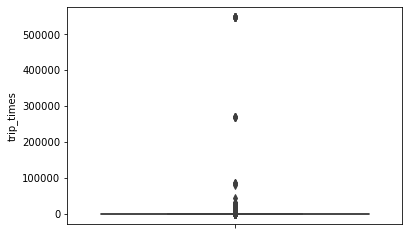

In [12]:
sns.boxplot(y = frame_with_durations['trip_times'])
plt.show()

In [13]:
for i in range(0,100,10):
    var = frame_with_durations['trip_times'].values
    var = np.sort(var)
    print('{} percentile value is {}'.format(i,np.percentile(var,i)))

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45


In [14]:
for i in range(90,101):
    var = frame_with_durations['trip_times'].values
    var = np.sort(var)
    print('{} percentile value is {}'.format(i,np.percentile(var,i)))

90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is 548555.6333333333


In [15]:
for i in range(1,11):
    x = 99 + float(i/10)
    var = frame_with_durations['trip_times'].values
    var = np.sort(var)
    print('{} percentile value is {}'.format(x,np.percentile(var,x)))

99.1 percentile value is 48.06666666666667
99.2 percentile value is 49.56666666666667
99.3 percentile value is 51.28333333333333
99.4 percentile value is 53.31666666666667
99.5 percentile value is 55.833333333333336
99.6 percentile value is 59.13333333333333
99.7 percentile value is 63.9
99.8 percentile value is 71.86666666666666
99.9 percentile value is 101.6
100.0 percentile value is 548555.6333333333


In [16]:
# Since as per Taxi regulations in a 24 hr period no one can drive for more than 12hrs so taking points which have time less than 720 min
frame_with_durations_mod = frame_with_durations[(frame_with_durations.trip_times>1)& (frame_with_durations.trip_times<720)]

In [17]:
frame_with_durations_mod

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421329e+09,5.285319
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420902e+09,9.983193
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420902e+09,10.746269
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420902e+09,16.071429
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420902e+09,9.318378
...,...,...,...,...,...,...,...,...,...,...
12615,2,1.00,-73.951988,40.786217,-73.953735,40.775162,7.55,3.933333,1.420897e+09,15.254237
12616,2,0.80,-73.982742,40.728184,-73.974976,40.720013,8.80,5.700000,1.420897e+09,8.421053
12617,1,3.40,-73.979324,40.749550,-73.969101,40.787800,14.30,13.283333,1.420897e+09,15.357591
12618,1,1.30,-73.999565,40.738483,-73.981819,40.737652,13.55,15.316667,1.420897e+09,5.092492


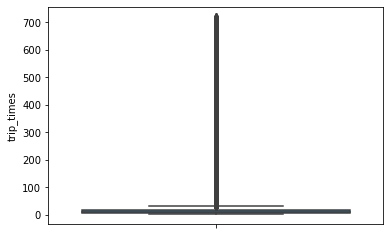

In [18]:
# Plot after data cleaning
sns.boxplot(y = frame_with_durations_mod['trip_times'])
plt.show()

KeyboardInterrupt: 

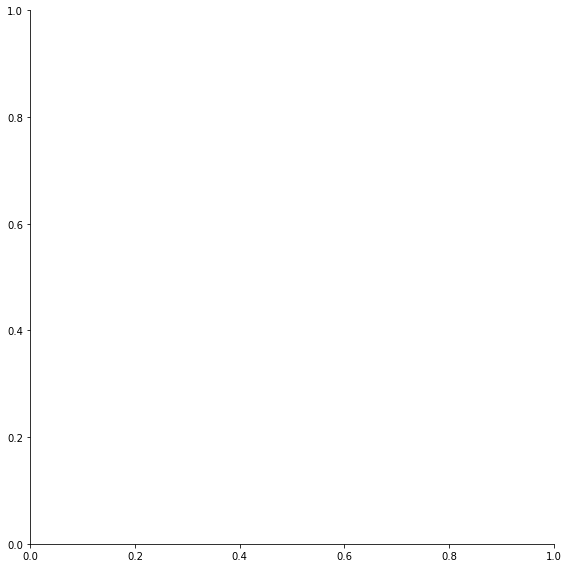

In [255]:
sns.FacetGrid(frame_with_durations_mod,size=8).map(sns.kdeplot,'trip_times').add_legend()
#looks like a skewed distribution

In [21]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_mod['log_times']=[math.log(i) for i in frame_with_durations_mod['trip_times'].values]

In [ ]:
#pdf of log values
sns.FacetGrid(frame_with_durations_mod,size=8).map(sns.kdeplot,'log_times').add_legend()

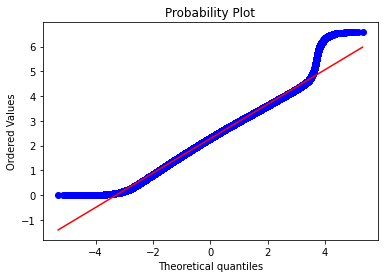

In [22]:
#Q-Q plot for checking if trip-times is log-normal
scipy.stats.probplot(frame_with_durations_mod['log_times'].values, plot=plt)
plt.show()

#### Q-Q plot shows that distribution is not log-normal

## Speed

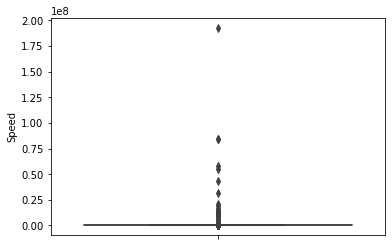

In [23]:
sns.boxplot(y = frame_with_durations_mod['Speed'])
plt.show()

In [24]:
for i in range(0,110,10):
    var = frame_with_durations_mod['Speed'].values
    var = np.sort(var)
    print('{} percentile value is {}'.format(i,np.percentile(var,i)))

0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is 192857142.85714284


In [25]:
for i in range(90,101):
    var = frame_with_durations_mod['Speed'].values
    var = np.sort(var)
    print('{} percentile value is {}'.format(i,np.percentile(var,i)))

90 percentile value is 20.186915887850468
91 percentile value is 20.916454400875093
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.751350551136035
100 percentile value is 192857142.85714284


In [26]:
for i in range(1,11):
    x = 99 + float(i/10)
    var = frame_with_durations_mod['Speed'].values
    var = np.sort(var)
    print('{} percentile value is {}'.format(x,np.percentile(var,x)))

99.1 percentile value is 36.310812903766646
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33033429478875
99.5 percentile value is 39.17580011612381
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338029086798095
99.8 percentile value is 42.86624389309318
99.9 percentile value is 45.310675074725154
100.0 percentile value is 192857142.85714284


In [27]:
#removing outliers based on the 99.9th percentile value
frame_with_durations_mod=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

In [28]:
#avg.speed of cabs in New-York
sum(frame_with_durations_mod["Speed"]) / float(len(frame_with_durations_mod["Speed"]))

12.450173996027528

#### The avg speed in Newyork speed is 12.45miles/hr, so a cab driver can travel 2 miles per 10min on avg.

## Trip Distance

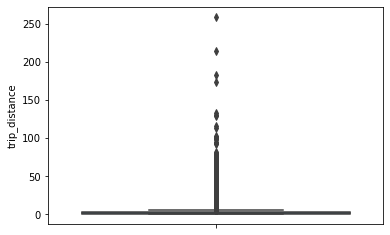

In [29]:
sns.boxplot(y="trip_distance", data =frame_with_durations_mod)
plt.show()

In [30]:
for i in range(0,110,10):
    var = frame_with_durations_mod['trip_distance'].values
    var = np.sort(var)
    print('{} percentile value is {}'.format(i,np.percentile(var,i)))

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.69
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 5.97
100 percentile value is 258.9


In [31]:
for i in range(90,101):
    var = frame_with_durations_mod['trip_distance'].values
    var = np.sort(var)
    print('{} percentile value is {}'.format(i,np.percentile(var,i)))

90 percentile value is 5.97
91 percentile value is 6.45
92 percentile value is 7.07
93 percentile value is 7.85
94 percentile value is 8.72
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.03
99 percentile value is 18.17
100 percentile value is 258.9


In [32]:
for i in range(1,11):
    x = 99 + float(i/10)
    var = frame_with_durations_mod['trip_distance'].values
    var = np.sort(var)
    print('{} percentile value is {}'.format(x,np.percentile(var,x)))

99.1 percentile value is 18.37
99.2 percentile value is 18.6
99.3 percentile value is 18.83
99.4 percentile value is 19.13
99.5 percentile value is 19.5
99.6 percentile value is 19.96
99.7 percentile value is 20.5
99.8 percentile value is 21.22
99.9 percentile value is 22.57
100.0 percentile value is 258.9


In [33]:
frame_with_durations_mod=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

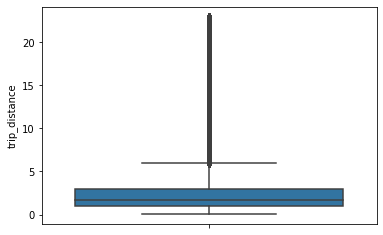

In [34]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_mod)
plt.show()

## Total Fare

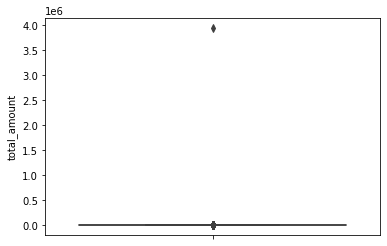

In [35]:
sns.boxplot(y="total_amount", data =frame_with_durations_mod)
plt.show()

In [36]:
for i in range(0,110,10):
    var = frame_with_durations_mod['total_amount'].values
    var = np.sort(var)
    print('{} percentile value is {}'.format(i,np.percentile(var,i)))

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is 3950611.6


In [37]:
for i in range(90,101):
    var = frame_with_durations_mod['total_amount'].values
    var = np.sort(var)
    print('{} percentile value is {}'.format(i,np.percentile(var,i)))

90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.8
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is 3950611.6


In [38]:
for i in range(1,11):
    x = 99 + float(i/10)
    var = frame_with_durations_mod['total_amount'].values
    var = np.sort(var)
    print('{} percentile value is {}'.format(x,np.percentile(var,x)))

99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.27224000003189
100.0 percentile value is 3950611.6


# Removing all outliers

In [39]:
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [40]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


# Data-preperation
## Clustering/Segmentation

* What I intend to do is divide NewYork city into different regions and for each region I will predict the taxi pickups in a ten minute interval

* Since the average speed came out to be 12.45 miles/hr it means that in 10 minutes cab can roughly travel 2 miles.
* So if there is a high pickup in the adjoining area it will make sense for taxi driver to travel to adjoining area, but the adjoining area shouldn't be too far and can be covered in ten minutes or so. 
* Also the inter cluster distance shouldn't be too small
* Hence while clustering we have to choose number of clusters which gives high number of clusters whose intercluster distance is less than 2 miles and minimum intercluster distance is atleast 0.5 miles


### Making regions

In [41]:
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.0945442325142662 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.7131298007388065 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 22.0 
Min inter-cluster distance =  0.5185088176172186 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 32.0 
Min inter-cluster distance 

In [42]:
# Have choosen cluster_size=30 as it gives considerable % of clusters whose intercluster distance is less than 2 miles and min inter cluster distance is 0.51 miles
kmeans = MiniBatchKMeans(n_clusters=30, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])


In [43]:
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

# As we can see most pickups can be found in Manhattan area in which there are many offices. 

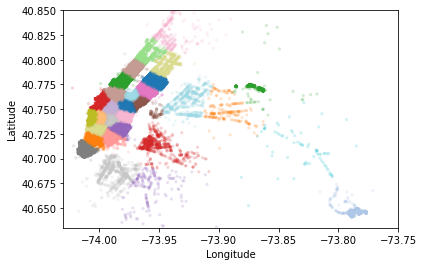

<Figure size 1152x576 with 0 Axes>

In [44]:
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.figure(figsize=(16,8))
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)


## Time Binning

* This is where I convert timings into 10 mins interval
* The timings are in gmt and I have converted that into est timezone as this is the timezone in which New York operates

In [45]:
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00

def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [46]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [47]:
# the trip_distance represents the number of pickups that are happend in that particular 10min intravel
# this data frame has two indices
# primary index: pickup_cluster (cluster number)
# secondary index : pickup_bins (we devid whole months time into 10min intravels 24*31*60/10 =4464bins)
jan_2015_groupby

trip_distance
pickup_cluster pickup_bins               
0              1                      138
               2                      262
               3                      311
               4                      326
               5                      381
...                                   ...
29             4459                    25
               4460                    27
               4461                    33
               4462                    32
               4463                    33

[131296 rows x 1 columns]

In [48]:
np.sort(jan_2015_frame['pickup_cluster'].values)


array([ 0,  0,  0, ..., 29, 29, 29])

In [49]:
# upto now we cleaned data and prepared data for the month 2015,

# now do the same operations for months Jan, Feb, March of 2016
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 22437
Number of outliers from fare analysis: 5476
Total outliers removed 308177
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers fro

# Smoothing

In [50]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,30):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [51]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [52]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(30):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  26
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  30
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  150
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  35
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  170
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  40
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  320
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  35
----------

there are two ways to fill up these values
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

In [53]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,30):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [54]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,30):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions



In [55]:

#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

In [56]:
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have 4464 values, therefore 30*4464 = 133920 (length of the jan_2015_fill)
print("number of 10min intravels among all the clusters ",len(jan_2015_fill))

number of 10min intravels among all the clusters  133920


In [57]:
# why we choose, these methods and which method is used for which data?

# Ans: consider we have data of some month in 2015 jan 1st, 10 _ _ _ 20, i.e there are 10 pickups that are happened in 1st 
# 10st 10min intravel, 0 pickups happened in 2nd 10mins intravel, 0 pickups happened in 3rd 10min intravel 
# and 20 pickups happened in 4th 10min intravel.
# in fill_missing method we replace these values like 10, 0, 0, 20
# where as in smoothing method we replace these values as 6,6,6,6,6, if you can check the number of pickups 
# that are happened in the first 40min are same in both cases, but if you can observe that we looking at the future values 
# wheen you are using smoothing we are looking at the future number of pickups which might cause a data leakage.

# so we use smoothing for jan 2015th data since it acts as our training data
# and we use simple fill_misssing method for 2016th data.



In [58]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

for i in range(0,30):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])

# print(len(regions_cum))
# 30
# print(len(regions_cum[0]))
# 13104

## Time series and Fourier Transforms

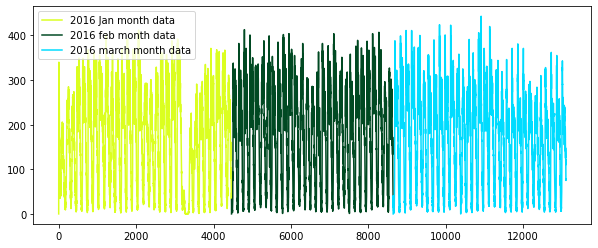

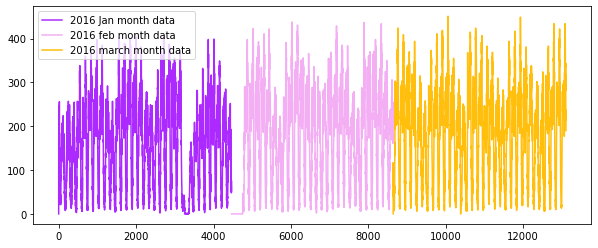

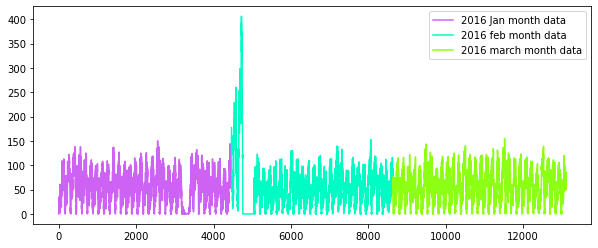

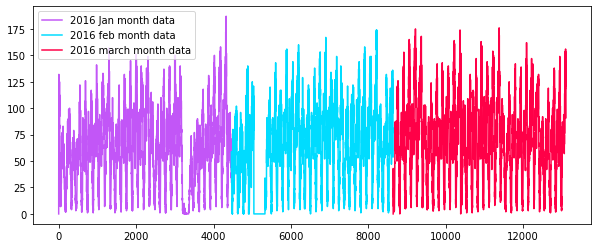

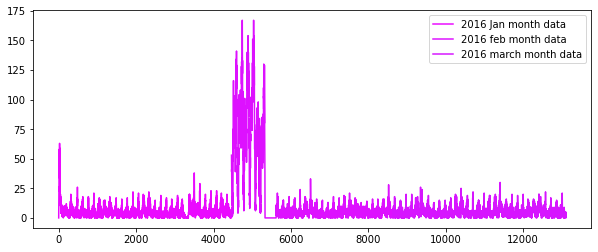

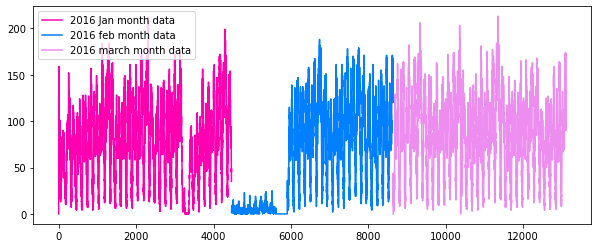

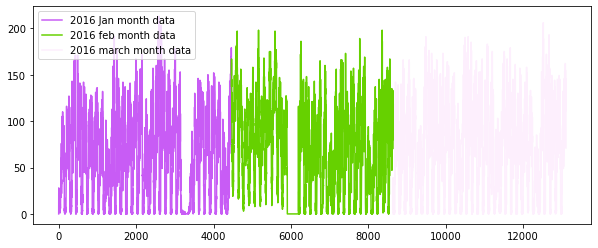

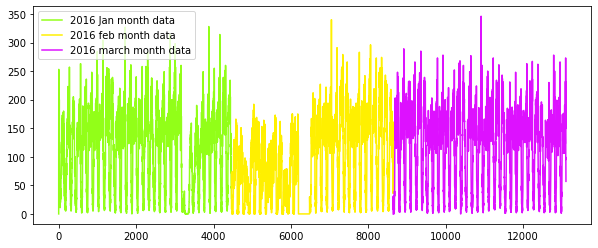

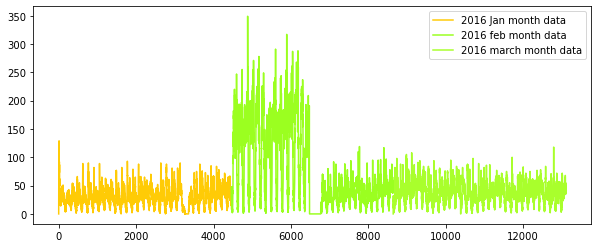

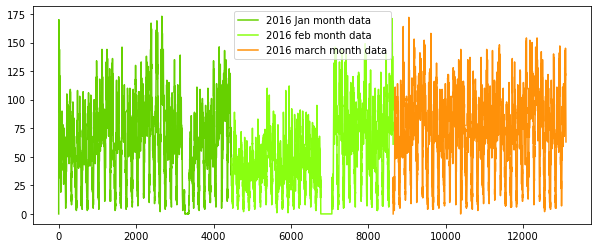

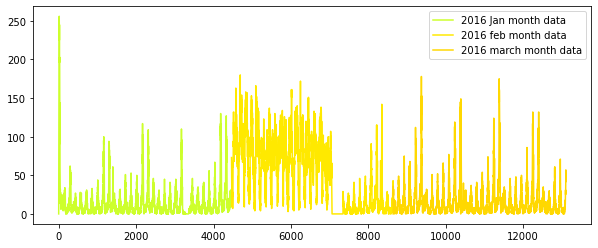

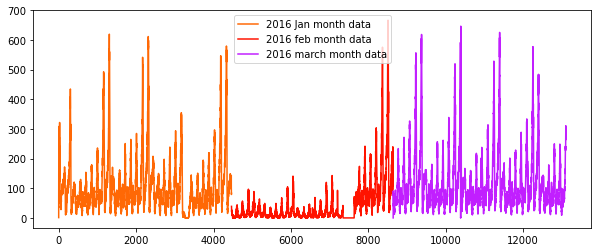

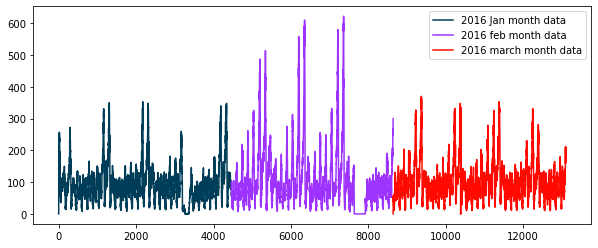

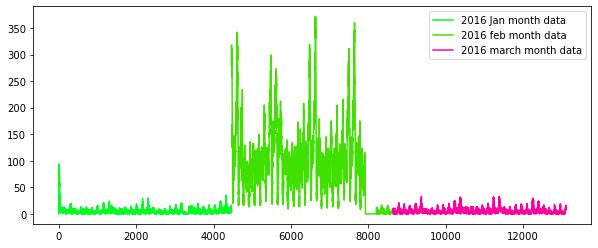

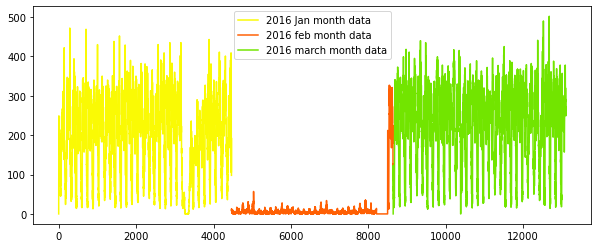

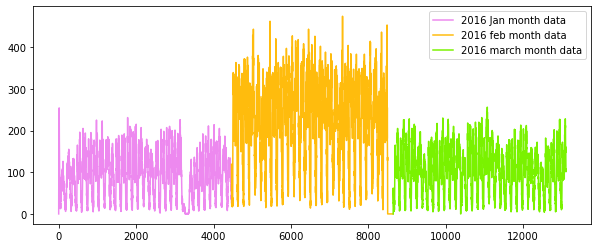

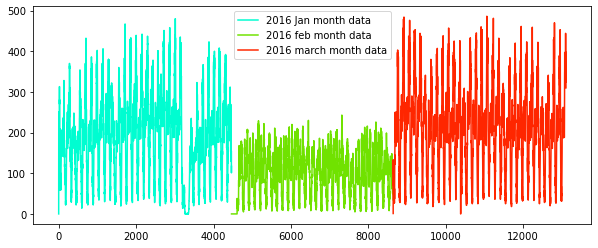

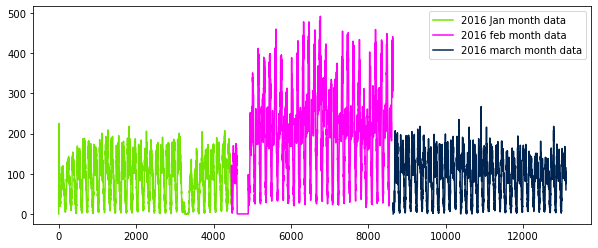

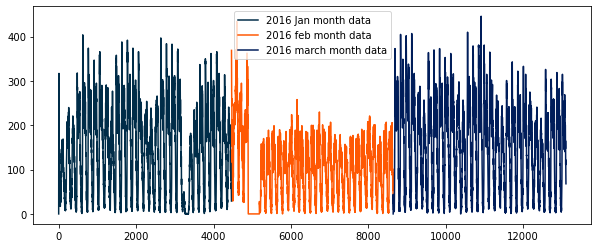

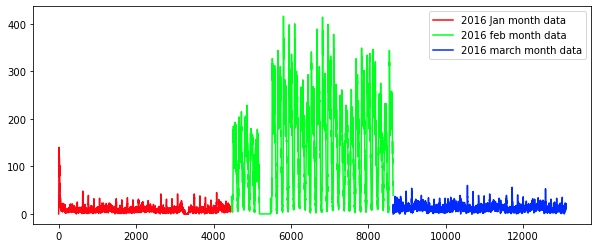

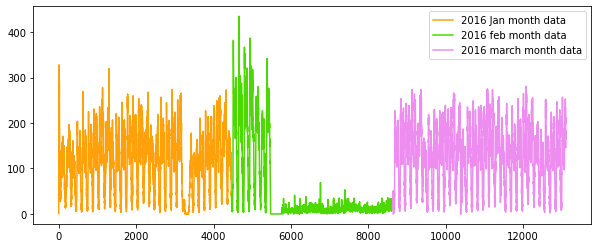

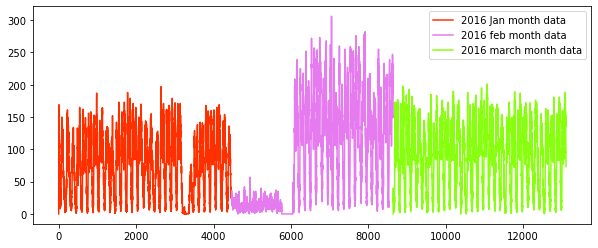

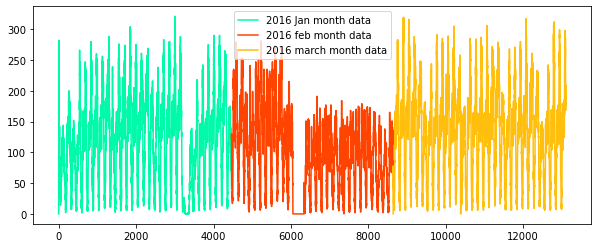

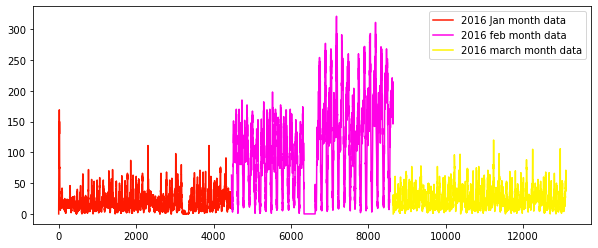

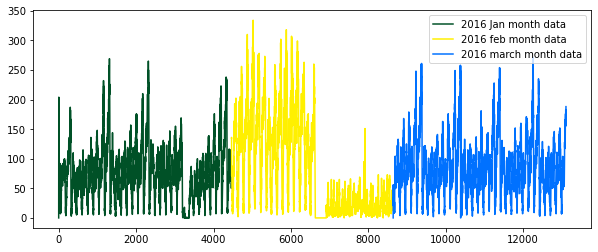

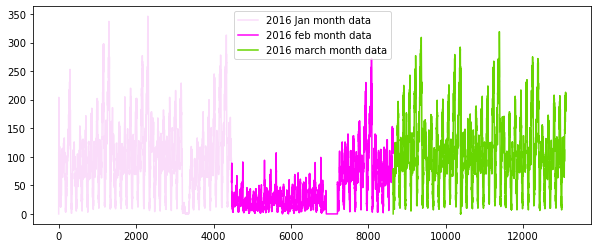

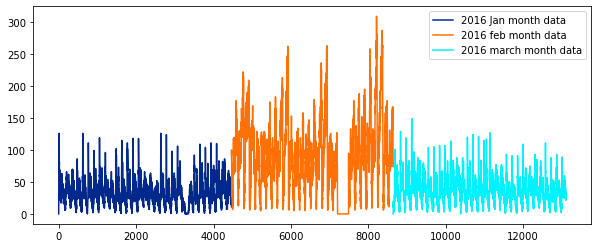

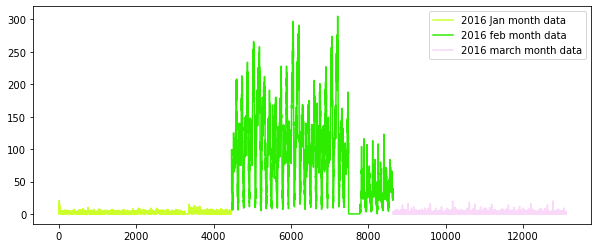

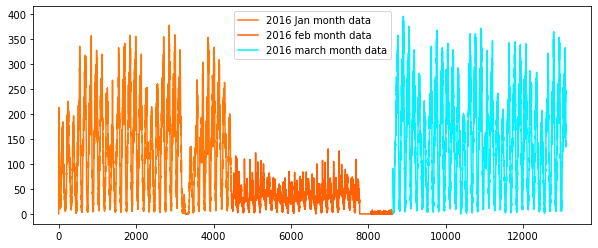

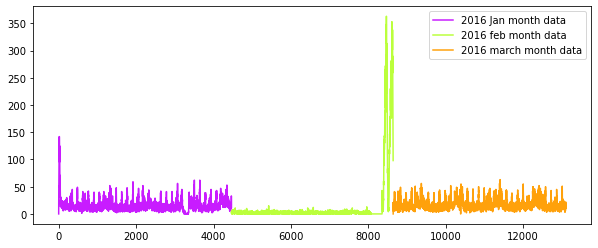

In [59]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))
for i in range(30):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2016 Jan month data')
    plt.plot(second_x,regions_cum[i][4464:8640], color=uniqueish_color(), label='2016 feb month data')
    plt.plot(third_x,regions_cum[i][8640:], color=uniqueish_color(), label='2016 march month data')
    plt.legend()
    plt.show()

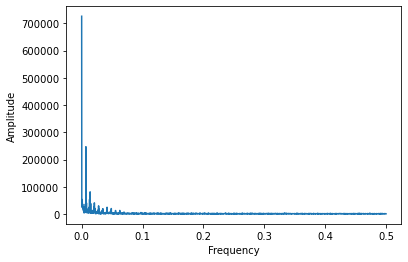

In [60]:
Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [61]:
jan_2015_smooth

[69,
 69,
 262,
 311,
 326,
 381,
 363,
 373,
 344,
 360,
 339,
 374,
 328,
 334,
 312,
 294,
 276,
 219,
 203,
 205,
 172,
 171,
 153,
 134,
 134,
 123,
 117,
 132,
 69,
 73,
 65,
 45,
 50,
 100,
 34,
 47,
 39,
 43,
 46,
 51,
 57,
 54,
 54,
 48,
 52,
 38,
 57,
 63,
 61,
 44,
 47,
 64,
 46,
 64,
 54,
 80,
 68,
 80,
 88,
 86,
 105,
 107,
 105,
 122,
 140,
 156,
 115,
 143,
 151,
 172,
 160,
 179,
 149,
 192,
 196,
 174,
 187,
 213,
 193,
 188,
 189,
 201,
 212,
 198,
 192,
 194,
 191,
 180,
 182,
 196,
 189,
 177,
 207,
 220,
 188,
 191,
 188,
 208,
 182,
 176,
 162,
 154,
 169,
 194,
 186,
 165,
 188,
 170,
 161,
 160,
 208,
 175,
 188,
 166,
 171,
 177,
 178,
 129,
 142,
 143,
 132,
 152,
 127,
 130,
 143,
 120,
 133,
 113,
 101,
 124,
 113,
 124,
 133,
 101,
 92,
 83,
 123,
 127,
 96,
 92,
 76,
 80,
 74,
 54,
 69,
 54,
 66,
 35,
 80,
 102,
 54,
 43,
 25,
 30,
 31,
 26,
 28,
 18,
 16,
 15,
 17,
 21,
 14,
 13,
 10,
 8,
 10,
 9,
 11,
 7,
 13,
 15,
 21,
 16,
 20,
 22,
 18,
 25,
 34,
 44,

In [62]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016

ratios_jan = pd.DataFrame()
ratios_jan['Given'] = jan_2015_smooth
ratios_jan['Prediction'] = jan_2016_smooth
ratios_jan['Ratios'] = ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [63]:
ratios_jan

,Given,Prediction,Ratios
0,69,0,0.000000
1,69,106,1.536232
2,262,243,0.927481
3,311,299,0.961415
4,326,328,1.006135
...,...,...,...
133915,25,24,0.960000
133916,27,33,1.222222
133917,33,17,0.515152
133918,32,21,0.656250


## Modelling: Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations 
1. Using Ratios of the 2016 data to the 2015 data i.e $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$
2. Using Previous known values of the 2016 data itself to predict the future values

In [64]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 3 is optimal for getting the best results using Moving Averages using previous Ratio values therefore we get $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3})/3 \end{align}$

Next we use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [65]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
'''ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')'''
print ("Moving Averages (Ratios) - MAPE: ",mean_err[0],"      MSE: ",median_err[0])

Moving Averages (Ratios) - MAPE:  0.1628685972027342       MSE:  561.0487977897252


In [66]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 1 is optimal for getting the best results using Moving Averages using previous 2016 values therefore we get $\begin{align}P_{t} = P_{t-1} \end{align}$

In [67]:
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
print ("Moving Averages (2016 Values) - MAPE: ",mean_err[1],"       MSE: ",median_err[1])

Moving Averages (2016 Values) - MAPE:  0.12651735674574424        MSE:  241.14901433691756


### Weighted Moving Averages
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones<br>

Weighted Moving Averages using Ratio Values - $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$

In [68]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 5 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $\begin{align} R_{t} = ( 5*R_{t-1} + 4*R_{t-2} + 3*R_{t-3} + 2*R_{t-4} + R_{t-5} )/15 \end{align}$

Weighted Moving Averages using Previous 2016 Values - $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$

In [69]:
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
print ("Weighted Moving Averages (Ratios) - MAPE: ",mean_err[2],"      MSE: ",median_err[2])

Weighted Moving Averages (Ratios) - MAPE:  0.1599661761243253       MSE:  548.5285170250896


In [70]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [71]:
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
print ("Weighted Moving Averages (2016 Values) -MAPE: ",mean_err[3],"MSE: ",median_err[3])

Weighted Moving Averages (2016 Values) -MAPE:  0.12121086157001072 MSE:  229.33734318996414


### Exponential  Weighted Moving Averages

https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average
Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [72]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [73]:
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
print ("Exponential Moving Averages (Ratios) -  MAPE: ",mean_err[4],"      MSE: ",median_err[4])

Exponential Moving Averages (Ratios) -  MAPE:  0.1593403910652334       MSE:  546.5861260454002


$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [74]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [75]:
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')
print ("Exponential Moving Averages (2016 Values) - MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Exponential Moving Averages (2016 Values) - MAPE:  0.1209639974233378       MSE:  226.0377688172043


## Comparison between baseline models
We have chosen our error metric for comparison between models as <b>MAPE (Mean Absolute Percentage Error)</b> so that we can know that on an average how good is our model with predictions and <b>MSE (Mean Squared Error)</b> is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

In [76]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.1628685972027342       MSE:  561.0487977897252
Moving Averages (2016 Values) -                        MAPE:  0.12651735674574424        MSE:  241.14901433691756
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.1599661761243253       MSE:  548.5285170250896
Weighted Moving Averages (2016 Values) -               MAPE:  0.12121086157001072       MSE:  229.33734318996414
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.1593403910652334       MSE:  546.5861260454002
Exponential Moving Averages (2016 Values) -         MAPE:  0.120963997423

From the above matrix it is inferred that the best forecasting model for our prediction would be:-
$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$ i.e Exponential Moving Averages using 2016 Values

## Regression Models

### Train-Test Split
Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

In [77]:
# Total number of data = (jan 2016 ten minutes bin + feb 2016 10 mins bin + march 2016 10 mins bin)
# Total 10 mins bin for Jan : ((24hrs*60min)/10 min bin)*31 days for jan = 4464
# Total 10 mins bin for Feb : ((24hrs*60min)/10 min bin)*29 days for jan = 4176
# Total 10 mins bin for March : ((24hrs*60min)/10 min bin)*31 days for March = 4464
# Total number of data = 4464+4176+4464 = 13104

# region_cum contain pickup values for all the custers , for each 10 mins bin

# region_cum is like [[1,2,3,....13104],[1,2,3,......13104],[1,2,3,...13104].....]
# So len(region_cum) = 30 (Total clusters)
# len(region_cum) = 13104

# Here I attempt to make data to be used in machine learning regression models

# The features include last 5 day pickup values, cluster lattitude and longitude, week day and Exponential moving average
# model as a feature

number_of_time_stamps = 5 # for taking the number of pickups that happen in last 5 10mins bin

output = [] # number of pickups for each (13104-5=)13099 for each bins of each cluster

tsne_lat = [] # latitude centres for every clusters
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 30 lists]

tsne_long =[] # longitude centres for every clusters
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 30 lists]

tsne_weekday = []
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6

# its an numbpy array, of shape (392970, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []
tsne_feature = [0]*number_of_time_stamps
for i in range(0,30):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_long.append([kmeans.cluster_centers_[i][1]]*13099)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [78]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 30*13099 == len(output)*len(output[0])

True

In [79]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 

alpha = 0.3

predicted_values = []

predict_list = []

for r in range(0,30):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            
            predicted_values.append(0)
           
            continue
        predicted_values.append(predicted_value)
        
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
        
    predict_list.append(predicted_values[5:])
    predicted_values=[] 

In [80]:
len(predict_list[0])

13099

### Train-Test split

In [81]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [82]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,30)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,30)]

In [83]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(test_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 30 Number of data points in trian data 9169 Each data point contains 5 features
Number of data clusters 30 Number of data points in test data 3930 Each data point contains 5 features


In [84]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_long]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [85]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_long]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [86]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,30):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,30):
    test_new_features.extend(test_features[i])

In [87]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])
tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [88]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(275070, 9)


In [91]:
# Preparing the data frame for our test data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(117900, 9)


# Making ML models

## Using Linear Regression

In [205]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error
from statistics import mean
from sklearn.model_selection import GridSearchCV 

In [210]:
parameters= {'alpha' : [0.001,0.01,0.1,1,10,100,1000]}

ridge_model = Ridge(random_state=42)

search = GridSearchCV(ridge_model,param_grid=parameters,cv=5,scoring='neg_mean_absolute_percentage_error')
search.fit(df_train,tsne_train_output)



GridSearchCV(cv=5, estimator=Ridge(random_state=42),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='neg_mean_absolute_percentage_error')

In [211]:
search.best_estimator_

Ridge(alpha=100, random_state=42)

In [212]:
ridge_best_model = Ridge(alpha=100,random_state=42)
ridge_best_model.fit(df_train,tsne_train_output)
test_pred = ridge_best_model.predict(df_test)

test_pred_round = [round(i) for i in test_pred]

In [213]:
MAE_lr = mean_absolute_error(tsne_test_output, test_pred_round)/(sum(tsne_test_output)/len(tsne_test_output))

In [214]:
print('The MAPE is: ',MAE_lr)

The MAPE is:  0.11575362496129427


## Using XGBoost Regressor

In [227]:
params_xgb = {'n_estimators':[800,1100,1500],
             'max_depth':[3,7,11],
             'min_child_weight':[5,11,13],
             'subsample':[0.4,0.8],
             'colsample_bytree':[0.6,0.8]}

In [228]:
model_xgb = xgb.XGBRegressor(learning_rate = 0.1)

In [229]:
search_xgb = GridSearchCV(model_xgb,cv=5,n_jobs=-1,param_grid = params_xgb,verbose=100)

In [230]:
search_xgb.fit(df_train,tsne_train_output)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_param

In [231]:
search_xgb.best_params_

{'colsample_bytree': 0.6,
 'max_depth': 3,
 'min_child_weight': 13,
 'n_estimators': 800,
 'subsample': 0.4}

In [232]:
best_model_xgb = xgb.XGBRegressor(learning_rate = 0.1,n_estimators = 800,subsample=0.4,min_child_weight=13,max_depth = 3,colsample_bytree=0.6)

In [233]:
best_model_xgb.fit(df_train,tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=13, missing=nan, monotone_constraints='()',
             n_estimators=800, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.4,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [236]:
test_pred_xgb = best_model_xgb.predict(df_test)
test_pred_round_xgb = [round(i) for i in test_pred_xgb]


In [237]:
# Mean Absolute % error
MAE_xgb = mean_absolute_error(tsne_test_output, test_pred_round_xgb)/(sum(tsne_test_output)/len(tsne_test_output))
print('The MAPE for XGBoost regressor is: ', MAE_xgb)

The MAPE for XGBoost regressor is:  0.11448942807228132


In [240]:
# Feature importances for XGB
print(best_model_xgb.feature_importances_)
print(df_train.columns)
# exp-avg is the most important feature

[0.00125464 0.05342004 0.00119221 0.01695684 0.32990548 0.00121464
 0.00138443 0.00088097 0.59379077]
Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg'],
      dtype='object')


## Using Random Forest

In [243]:
model_rf = RandomForestRegressor()
param_rf = {'min_samples_leaf': [3,5,7,9],
                        'min_samples_split':[5,7,9,11],
                        'n_estimators':[100,300,500,800]
           }

In [246]:
search_rf = GridSearchCV(model_rf,param_grid=param_rf,n_jobs=-1,verbose=20)

In [247]:
search_rf.fit(df_train,tsne_train_output)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'min_samples_leaf': [3, 5, 7, 9],
                         'min_samples_split': [5, 7, 9, 11],
                         'n_estimators': [100, 300, 500, 800]},
             verbose=20)

In [248]:
search_rf.best_params_

{'min_samples_leaf': 9, 'min_samples_split': 7, 'n_estimators': 800}

In [251]:
best_model_rf = RandomForestRegressor(min_samples_leaf=9,min_samples_split=7,n_estimators=800)
best_model_rf.fit(df_train,tsne_train_output)

RandomForestRegressor(min_samples_leaf=9, min_samples_split=7, n_estimators=800)

In [252]:
test_pred_rf = best_model_rf.predict(df_test)
test_pred_round_rf = [round(i) for i in test_pred_rf]

In [253]:
# Mean Absolute % error
MAE_rf = mean_absolute_error(tsne_test_output, test_pred_round_rf)/(sum(tsne_test_output)/len(tsne_test_output))
print('The MAPE for Random Forest regressor is: ', MAE_rf)

The MAPE for Random Forest regressor is:  0.11322427548558998


# Comparison between Models

In [254]:
print('The MAPE for Linear Regressor is: ',MAE_lr)
print('The MAPE for XGBoost Regressor is: ',MAE_xgb)
print('The MAPE for Random Forest Regressor is: ',MAE_rf)

The MAPE for Linear Regressor is:  0.11575362496129427
The MAPE for XGBoost Regressor is:  0.11448942807228132
The MAPE for Random Forest Regressor is:  0.11322427548558998
